In [2]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 250 # Number of time points
time = np.arange(n_points)

# Generate base binary time series using Bernoulli distribution
X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)

# Introduce causal relationships
for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.7 * X1[t-1] + 0.1)
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.8 * X2[t-1] + 0.2)


print(X1)

X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.3 for i in range(len(X3)) if X3[i] > 0]

[1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1
 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0
 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1
 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1
 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1
 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1
 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0]


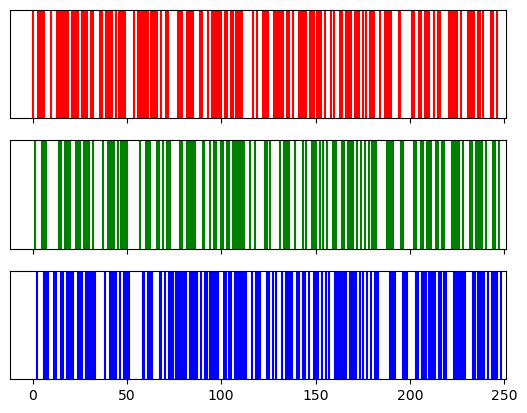

In [4]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"
    

In [6]:
import torch 

class ProbRNN(nn.Module):
    def __init__(self, memory_size):
        super().__init__()

        self.memory_size = memory_size
        self.linear = nn.Sequential(nn.Linear(self.memory_size, 64), nn.Tanh())
        self.lstm = nn.LSTM(input_size = 64, hidden_size = 128, num_layers = 2, batch_first = True)
        self.linear_mu = nn.Sequential(nn.Linear(128, self.memory_size))
        self.linear_std = nn.Sequential(nn.Linear(128, self.memory_size))
        self.gmm_weights = nn.Parameter(nn.Softmax(dim=1)((torch.rand(size = (1, self.memory_size)))))


    def forward(self, x):

      x = self.linear(x)
      x, _ = self.lstm(x)
      mu = self.linear_mu(x)
      std = self.linear_std(x)
      std = torch.abs(std)


      new_X = self.sample(mu, std)
      mix_dist = self.build_distrib(mu, std)
      log_prob = mix_dist.log_prob(new_X)

      return new_X, log_prob


    def build_distrib(self, mus, stds):
      
        ### This should not work if batch_size != 1. Yet to decide how to deal with this behaviour.

      component_dist = torch.distributions.Normal(mus, stds)
      mix_weight = torch.distributions.Categorical(torch.abs(self.gmm_weights))
      mix_dist = torch.distributions.MixtureSameFamily(mix_weight, component_dist)
      self.mix_dist = mix_dist

      return mix_dist

    def sample(self, mu, std):

      X =  mu + torch.randn_like(std)*std

      return X


In [7]:
def get_inter_times(t : torch.Tensor, t_end : int):
    # t.sort()

    t = t.cpu().numpy()
    tau = np.diff(t, prepend = 0, append=t_end)
    
    return torch.tensor(tau, dtype=torch.float32, device=device)

In [8]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

seq_lengths = [len(t) for t in processes]

t_end_scalar = 30
t_end = [t_end_scalar]*len(processes)

taus = list(map(lambda p: get_inter_times(*p), zip(processes, t_end)))
taus = [taus[i] for i in range(3)]

padded_taus = pad_sequence(taus, batch_first=True)  # (B, L)
# padded_taus[-1].cumsum(dim = 0)

In [9]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):
        
        super().__init__()
        
        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)
        self.GrangerMatrix = nn.Parameter(torch.Tensor(self.n_processes, self.n_processes)) # nn.Parameter(nn.Parameter(torch.Tensor(self.n_processes, self.n_processes)))
        self.models = nn.ModuleList([ProbRNN(self.memory_dim) for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4) 

    def e_step(self, in_weights: torch.Tensor, points_current_pp):
        
        """
        Return the causes for each event of the current_p
        
        """
        
        n = len(points_current_pp)
        rv = []
    
        for i in range(n):
            cause = F.gumbel_softmax(
                in_weights,
                hard = True
            )
            cause = torch.argmax(cause, dim = 0)
            rv.append(cause)
    
        
        
        return rv

    def em_step(self, n_steps):
        dic = {}
        
        for i in range(self.n_processes):
            dic[i] = []
        
        for step in range(n_steps):
            self.causes = []
            for i_proc in range(self.n_processes):
                rv = self.e_step(
                    self.GrangerMatrix[i_proc],
                    self.processes[i_proc]
                )
                self.causes.append(rv)
            
            
            for i_proc in range(self.n_processes):
                
                causes_to_ith = self.causes[i_proc] ## causes of ith_proc
                
                for j, cause_to_ith in enumerate(causes_to_ith):
                    
                    cause_to_ith = cause_to_ith.item()
                    effect_j_on_i = self.sweep_dict[i_proc][cause_to_ith]
                    
                    if (cause_to_ith == i_proc) and j>=self.memory_dim:
                        X_to_pass = processes[i_proc][j - self.memory_dim : j]
                        X_to_pass = X_to_pass.flip(dims = (0,)) - X_to_pass[0]
                        #self.X_to_pass = X_to_pass
                        #print(X_to_pass.shape)
                        loss = self.m_step(i_proc, X_to_pass.unsqueeze(0)) 
                        dic[i_proc].append(loss)
                    
                    elif len(effect_j_on_i) > j:
                        X_to_pass = effect_j_on_i[j]
                        #print(X_to_pass.shape)
                        #self.X_to_pass = X_to_pass
                        loss = self.m_step(i_proc, X_to_pass.unsqueeze(0))
                        dic[i_proc].append(loss)
                
                if (step + 1) % 25 == 0 or step == 0:
                                print(f'Step: {step + 1}, Model: {i_proc}, Loss: {loss}')
                    
    
        return dic

    def m_step(self, i_proc, X):
        model = self.models[i_proc]
        
        self.optimizer.zero_grad()
        z, loss = model(X)
        loss = -1*loss
        loss = loss.sum()
        
        if not (torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            self.optimizer.step()
        else:
            print(f'NaN found in epoch: {step}')    

        return loss.item()

    def make_sweep_dict(self):
        
        dic = {}
        for i in range(self.n_processes):
            target = processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)
        return dic


    def sweep(self, pa, pc):
      events = []
      for ia in pa:
        events.append((ia, 'a'))
      for ic in pc:
        events.append((ic, 'c'))
    
      lim = self.memory_dim
    
      events.sort()
      mem = []
      ret = []
      for [t, e] in events:
    
        if e == 'c':
          if len(mem) >= lim:
            mem.pop(0)
          mem.append(t)
    
        if e == 'a':
          ## memoria ainda nao esta cheia:
          if len(mem) < lim:
            continue
          ## recupere os deltas desse tempo para o tempo causa
          pp = []
          for tc in mem:
            pp.append(t - tc)
          ret.append(pp)
    
      return torch.tensor(ret, dtype = torch.float)

In [10]:
mpp = GrangerMPP(processes)
l = mpp.em_step(n_steps = 150)

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

In [ ]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [ ]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [ ]:
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        ax.axvline(x=t, color = colors[cause[idx]])
    ax.get_yaxis().set_visible(False)

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex = True)

idx = 2
proc_to_plot = processes[idx].detach().cpu().numpy()
_plot_tick_bars(proc_to_plot, ax[0], color = colors[idx])
_plot_tick_bars_causes(proc_to_plot, ax[1], cause = mpp.causes[idx])


In [ ]:
X = mpp.GrangerMatrix.detach().cpu().numpy()
plt.imshow(X)
plt.axis('off')
plt.colorbar()

In [ ]:
mpp.GrangerMatrix

In [ ]:
X = mpp.GrangerMatrix.detach().cpu().numpy()
X = (X.T/X.sum(axis = 1)).T
plt.imshow(X)
plt.axis('off')
plt.colorbar()

In [ ]:
X